In [85]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>.output_scroll { height:20em !important; }</style>"))

In [8]:
from numba import jit
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2 as cv
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import cdist
import numpy as np

In [9]:
import spectral.io.spyfile as spyfile
import spectral.io.aviris as aviris
import spectral.io.envi as envi
import spectral.io.erdas as erdas

import tifffile as tfl


def open_SpyFile(path_lan: str):
    '''
    Opens a hyperspectral image in LAN format.

    Parameters
    ----------
    path_lan : str
        Path to the LAN file to be opened.

    Returns
    -------
    SpectralLibrary
        A `SpyFile` object containing the hyperspectral data.

    Examples
    --------
    >>> from your_module import open_SpyFile
    >>> hsi = open_SpyFile("example.lan")
    >>> print(hsi)
    SpyFile: [shape=(100, 100, 224), dtype=float32]
    '''
    
    hsi = spyfile.open(path_lan)
    return hsi
    
    
def open_ENVI(path_hdr: str, path_img: str):
    '''
    Opens a hyperspectral image in ENVI format and converts it to a NumPy array.

    Parameters
    ----------
    path_hdr : str
        Path to the ENVI header file (.hdr).
    path_img : str
        Path to the ENVI image file (.img).

    Returns
    -------
    np.ndarray
        A NumPy array of the hyperspectral data, with `dtype=float`.

    Notes
    -----
    - The ENVI image is opened as a memory-mapped array and then loaded fully into memory as a float array.

    Examples
    --------
    >>> from your_module import open_ENVI
    >>> hsi = open_ENVI("example.hdr", "example.img")
    >>> print(hsi.shape)
    (100, 100, 224)  # Example dimensions
    '''
    
    hsi_envi = envi.open(path_hdr, path_img)
    hsi = np.array(hsi_envi.open_memmap(writble=True), dtype=float)
    return hsi

    
def open_AVIRIS(path_rfl: str, path_spc: str):
    '''
    Opens a hyperspectral image in AVIRIS format.

    Parameters
    ----------
    path_rfl : str
        Path to the AVIRIS reflectance data file (.rfl).
    path_spc : str
        Path to the AVIRIS spectral calibration file (.spc).

    Returns
    -------
    SpectralLibrary
        A `SpyFile` object containing the AVIRIS hyperspectral data.

    Examples
    --------
    >>> from your_module import open_AVIRIS
    >>> hsi = open_AVIRIS("example.rfl", "example.spc")
    >>> print(hsi)
    SpyFile: [shape=(100, 100, 224), dtype=float32]
    '''
    hsi = aviris.open(path_rfl, path_spc)
    return hsi


def open_ERDAS(path: str):
    '''
    Opens a hyperspectral image in ERDAS Imagine format.

    Parameters
    ----------
    path : str
        Path to the ERDAS Imagine file to be opened.

    Returns
    -------
    SpectralLibrary
        A `SpyFile` object containing the hyperspectral data.

    Examples
    --------
    >>> from your_module import open_ERDAS
    >>> hsi = open_ERDAS("example.img")
    >>> print(hsi)
    SpyFile: [shape=(100, 100, 224), dtype=float32]
    '''
    
    hsi = erdas.open(path)
    return hsi


def open_TIF(path_tif: str):
    '''
    Opens a hyperspectral image in GeoTIFF format.

    Parameters
    ----------
    path_tif : str
        Path to the GeoTIFF file to be opened.

    Returns
    -------
    np.ndarray
        A NumPy array containing the hyperspectral data.

    Notes
    -----
    - The GeoTIFF data is loaded into memory using the `tifffile` library and copied as a NumPy array.

    Examples
    --------
    >>> from your_module import open_TIF
    >>> hsi = open_TIF("example.tif")
    >>> print(hsi.shape)
    (100, 100, 224)  # Example dimensions
    '''
    
    hsi_tif = tfl.TiffFile(path_tif)
    hsi = hsi_tif.asarray().copy()
    return hsi

In [149]:
def rayleigh_scattering(spectral_data: np.ndarray, inplace=False, verbose=True):
    '''
    Compute the Rayleigh scattering signature for a spectral dataset.

    Parameters:
    - spectral_data (np.ndarray): A multi-dimensional NumPy array where the last dimension represents spectral bands.
    - inplace (bool): If True, the function modifies `spectral_data` by subtracting the computed Rayleigh signature.
    - verbose (bool): If True, displays a progress bar using `tqdm` during processing.

    Returns:
    - np.ndarray: A 1D array containing the Rayleigh scattering signature for each spectral band.
    '''
    
    if not isinstance(spectral_data, np.ndarray):
        raise TypeError('spectral_data must be an np.ndarray')
        
    bands = spectral_data.shape[-1]
    rayleigh_offsets = np.zeros(shape=bands, dtype=float)
    for i in tqdm(range(bands), disable=not verbose):
        layer = spectral_data[..., i]
        rayleigh_offsets[i] = layer[layer > 0].min()
    
    if inplace:
        spectral_data -= rayleigh_offsets
        spectral_data[spectral_data < 0] = 0
        
    return rayleigh_offsets


def sigma_maximum_filter(spectral_data: np.ndarray, sigma: float = 3, thresholds: np.ndarray = None):
    '''
    Applies a sigma-based maximum filter to the input spectral data, capping values 
    based on a calculated threshold of mean + sigma * standard deviation.

    Parameters
    ----------
    spectral_data : np.ndarray
        The input spectral data array. It is expected to have a shape where 
        the last dimension corresponds to the spectral bands.
    sigma : float, optional
        The multiplier for the standard deviation used in calculating the threshold, 
        by default 3.
    thresholds : np.ndarray, optional
        An array to store the calculated thresholds. If provided, it must have a shape 
        matching the last dimension of `spectral_data`. If `None`, thresholds are 
        computed and returned internally, by default None.

    Returns
    -------
    np.ndarray
        The filtered spectral data with values capped by the calculated thresholds.

    Notes
    -----
    - If `thresholds` is provided, it will be updated in-place with the calculated 
      threshold values.
    - The filtering is applied to all bands of the spectral data independently.

    Examples
    --------
    Apply a sigma filter to a 3D spectral dataset:
    
    >>> import numpy as np
    >>> data = np.random.rand(100, 100, 10) * 10  # Example spectral data
    >>> thresholds = np.zeros(data.shape[-1:], dtype=np.float32)
    >>> result_with_thresholds = sigma_maximum_filter(data, sigma=2, thresholds=thresholds)
    >>> thresholds  # Updated thresholds
    array([...])
    '''
    
    if not isinstance(spectral_data, np.ndarray):
        raise TypeError('spectral_data must be an np.ndarray')
    
    axes = tuple(range(len(spectral_data.shape) - 1))
    layer_mean = spectral_data.mean(axis=axes, keepdims=True)
    layer_std = spectral_data.std(axis=axes, keepdims=True)
    
    if thresholds is None:
        thresholds = np.zeros(shape=spectral_data.shape[-1:])
    elif thresholds.shape != spectral_data.shape[-1:]:
        raise ValueError("Provided thresholds must have the same shape as the spectral axis of the data.")
    thresholds[...] = layer_mean + (layer_std * sigma)
    
    return np.minimum(spectral_data, thresholds)

In [150]:
hdr = 'C:/Users/konst/Documents/GitHub/Moffett-Field-labeling/data/MoffetField/f080611t01p00r07rdn_c_sc01_ort_img.hdr'
img = 'C:/Users/konst/Documents/GitHub/Moffett-Field-labeling/data/MoffetField/f080611t01p00r07rdn_c_sc01_ort_img'
    
hsi = open_ENVI(hdr, img)
hsi = np.rot90(hsi)
hsi.shape

(753, 1924, 224)

In [151]:
rayleigh_offsets = rayleigh_scattering(hsi, inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████| 224/224 [00:06<00:00, 33.83it/s]


In [154]:
thresholds = np.zeros(hsi.shape[-1:], dtype=float)
hsi = sigma_maximum_filter(hsi, sigma=3, thresholds=thresholds)

In [155]:
band = sigma_maximum_filter(hsi[..., 93][..., np.newaxis], sigma=3)[..., 0]

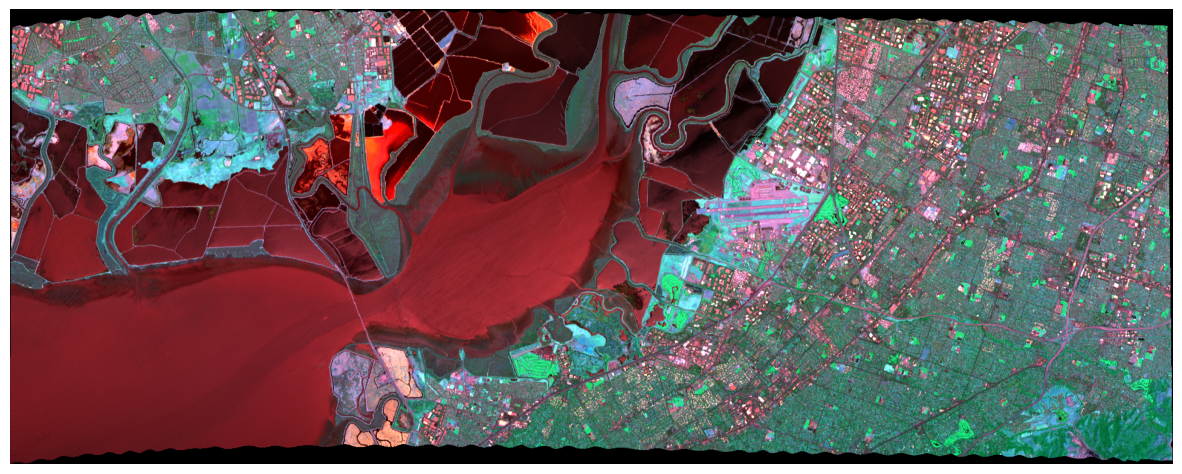

In [174]:
def simple_synthesize_rgb(band_data: list, sig_max_filt: float = None):
    '''
    Synthesizes an RGB image from ....

    Parameters
    ----------

    Returns
    -------
    np.ndarray
        A 3D array of shape (height, width, 3) representing the synthesized RGB image.
    '''
    
    if len(band_data) != 3:
        raise ValueError("`band_data` must contain exactly three bands for red, green, and blue bands.")
    
    if sig_max_filt is not None:
        band_data = [sigma_maximum_filter(band[..., np.newaxis], sigma=3)[..., 0] for band in band_data]
        
    band_data = [normalize(band) * 255 for band in band_data]
    
    rgb_image = np.stack(band_data, axis=-1)
    rgb_image = np.uint8(rgb_image)

    return rgb_image


rgb_image = simple_synthesize_rgb([hsi[..., 12], hsi[..., 93], hsi[..., 150]])
plt.figure(figsize=(15, 10))
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

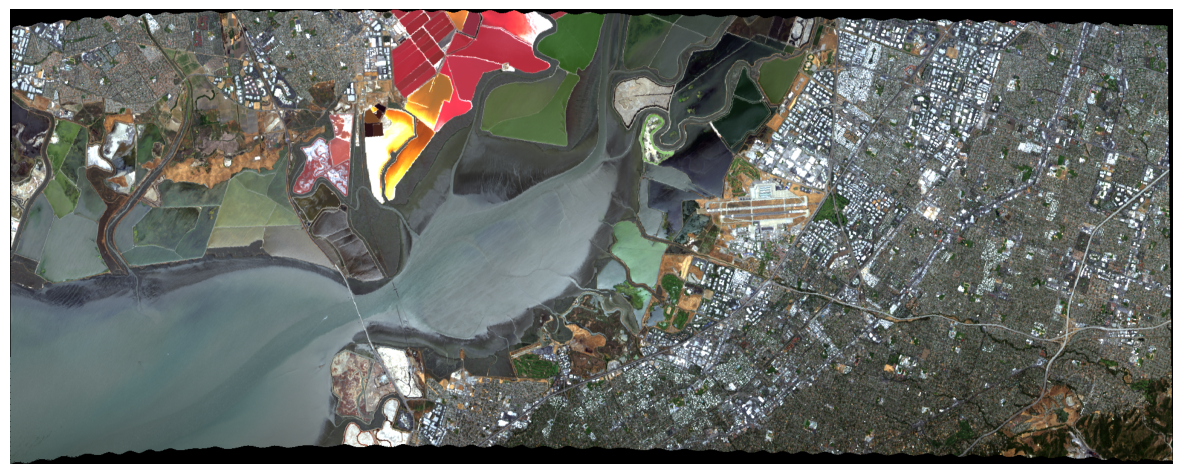

In [169]:
def normalize(array: np.ndarray):
    '''
    Normalizes a given NumPy array to the range [0, 1].

    The function scales the input array such that the minimum value in the array becomes 0 
    and the maximum value becomes 1. The formula used is:

    .. math::
        normalized\_value = \frac{value - min}{max - min}

    Parameters
    ----------
    array : np.ndarray
        A NumPy array to be normalized. The array can be of any shape or type that supports
        element-wise arithmetic operations.

    Returns
    -------
    np.ndarray
        A NumPy array of the same shape as the input, with values normalized to the range [0, 1].

    Examples
    --------
    >>> import numpy as np
    >>> array = np.array([1, 2, 3, 4, 5])
    >>> normalized_array = normalize(array)
    >>> print(normalized_array)
    [0.   0.25 0.5  0.75 1.  ]
    
    >>> array = np.array([[1, 2], [3, 4], [5, 6]])
    >>> normalized_array = normalize(array)
    >>> print(normalized_array)
    [[0.   0.2 ]
     [0.4  0.6 ]
     [0.8  1.  ]]
    '''
    
    return (array - array.min()) / (array.max() - array.min())

def hsi_synthesize_rgb(spectral_data: np.ndarray, rgb_bands: list | np.ndarray = None, wavelengths: list | np.ndarray = None):
    """
    Synthesizes an RGB image from hyperspectral data.

    Parameters
    ----------
    spectral_data : np.ndarray
        Hyperspectral image data, expected to be a 3D array of shape (height, width, bands).
    rgb_bands : list of int, optional
        A list containing the band indices for red, green, and blue channels, in that order.
        Must be of length 3. If provided, `wavelengths` is ignored.
    wavelengths : list of float, optional
        A list containing the wavelengths corresponding to each band in `spectral_data`.
        If provided, the closest wavelengths to 650 nm (red), 550 nm (green), and 450 nm (blue) are used.

    Returns
    -------
    np.ndarray
        A 3D array of shape (height, width, 3) representing the synthesized RGB image.

    Examples
    --------
    Using band indices directly:
    >>> spectral_data = np.random.rand(100, 100, 224)  # Example hyperspectral data
    >>> rgb_bands = [50, 100, 150]  # Example red, green, blue bands
    >>> rgb_image = synthesize_rgb(spectral_data, rgb_bands=rgb_bands)
    >>> print(rgb_image.shape)
    (100, 100, 3)

    Using wavelengths:
    >>> wavelengths = np.linspace(400, 700, 224)  # Example wavelength data
    >>> rgb_image = synthesize_rgb(spectral_data, wavelengths=wavelengths)
    >>> print(rgb_image.shape)
    (100, 100, 3)
    """
    if rgb_bands is None and wavelengths is None:
        raise ValueError("Either `rgb_bands` or `wavelengths` must be provided.")

    if rgb_bands is not None:
        if isinstance(rgb_bands, np.ndarray):
            rgb_bands = rgb_bands.tolist()

        if len(rgb_bands) != 3:
            raise ValueError("`rgb_bands` must contain exactly three indices for red, green, and blue bands.")
        red_idx, green_idx, blue_idx = rgb_bands
        
    elif wavelengths is not None:
        if isinstance(wavelengths, np.ndarray):
            wavelengths = wavelengths.tolist()
        
        if len(wavelengths) != spectral_data.shape[-1]:
            raise ValueError("The length of `wavelengths` must match the number of bands in `spectral_data`.")
        red_idx = np.argmin(np.abs(np.array(wavelengths) - 650))  # Closest to 650 nm (red)
        green_idx = np.argmin(np.abs(np.array(wavelengths) - 550))  # Closest to 550 nm (green)
        blue_idx = np.argmin(np.abs(np.array(wavelengths) - 450))  # Closest to 450 nm (blue)
    else:
        raise ValueError("Invalid parameters: provide either `rgb_bands` or `wavelengths`.")

    red_band = spectral_data[..., red_idx]
    red_band = normalize(red_band) * 255
    
    green_band = spectral_data[..., green_idx]
    green_band = normalize(green_band) * 255
    
    blue_band = spectral_data[..., blue_idx]
    blue_band = normalize(blue_band) * 255
    
    rgb_image = np.stack([red_band, green_band, blue_band], axis=-1)
    rgb_image = np.uint8(rgb_image)

    return rgb_image


rgb_image = hsi_synthesize_rgb(hsi, [29, 19, 9])
plt.figure(figsize=(15, 10))
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

In [163]:
rgb_image.shape

(1924, 224, 753)

In [58]:
class CosClust():
    '''
    A clustering algorithm based on cosine similarity. Groups samples into clusters based on a 
    threshold for cosine similarity and assigns labels to each sample.

    Parameters
    ----------
    threshold : float, optional
        The cosine similarity threshold for determining cluster membership. Default is 0.9.
    verbose : bool, optional
        If True, displays progress and additional information during the clustering process. Default is True.
    **kwargs
        Additional keyword arguments (currently not used).

    Attributes
    ----------
    threshold : float
        The cosine similarity threshold for clustering.
    labels : np.ndarray or None
        The cluster labels assigned to each sample. Initialized as `None` and populated after `fit` is called.
    reference_set : list
        A list of reference samples representing each cluster.

    Methods
    -------
    fit(source_data, y=None)
        Performs clustering on the input data and returns cluster labels.

    Examples
    --------
    >>> import numpy as np
    >>> data = np.random.rand(100, 50)  # 100 samples with 50 features each
    >>> model = CosClust(threshold=0.8, verbose=True)
    >>> labels = model.fit(data)
    >>> print(labels)
    array([0, 1, 0, 2, ..., 1])  # Example output
    '''
        
    def __init__(self, threshold: float = 0.9, **kwargs, verbose=True):
        self.threshold = threshold
        self.labels = None

        self.reference_set = []


    def fit(self, source_data: np.ndarray, y=None):
        '''
        Performs clustering on the given data based on cosine similarity.

        Parameters
        ----------
        source_data : np.ndarray
            A 2D array of shape (n_samples, n_features) where `n_samples` is the number of samples 
            and `n_features` is the number of features for each sample.
        y : Ignored
            Placeholder for compatibility, not used in this implementation.

        Returns
        -------
        np.ndarray
            A 1D array of shape (n_samples,) containing the cluster labels for each sample.

        Notes
        -----
        - The algorithm proceeds in two steps:
            1. Initial clustering based on the cosine similarity threshold.
            2. Adjustment of labels based on the reference set of cluster representatives.
        - Samples with no cluster assignment are labeled as `-1`.
        '''
        
        n_clust = 0
        self.labels = np.full(shape=source_data.shape[0], fill_value=-1, dtype=int)
        id_reference_set = []

        n_samples, _ = source_data.shape
        
        if verbose:
            print("CosClust take a step 1/2")
        for i in tqdm(range(n_samples), disable=not verbose):
            if self.labels[i] == -1:
                corr_array = 1 - cdist(source_data[i, np.newaxis], source_data, "cosine")[0]

                bool_mask = corr_array > self.threshold
                bool_mask[self.labels != -1] = False
                self.labels[bool_mask] = n_clust

                n_clust += 1

                id_reference_set.append(i)
                self.reference_set.append(source_data[i])

        tmp_labels = np.full(shape=source_data.shape[0], fill_value=-1, dtype=int)
        
        if verbose:
            print("CosClust take a step 2/2")
        for i in tqdm(range(n_samples), disable=not verbose):
            tmp_corr_array = 1 - cdist(source_data[i, np.newaxis], source_data[id_reference_set], "cosine")[0]
            if id_reference_set[self.labels[i]] == i:
                tmp_corr_array[self.labels[i]] = 0.0

            tmp_labels[i] = tmp_corr_array.argmax()

        self.labels = tmp_labels

        return self.labels

In [108]:
def SWEMD(data: np.ndarray, number_of_modes:int = 4, windows_size: list = [3], verbose: bool = True):
    '''
    Returns for a 1D signal its IMF and windows for each of them.

    Parameters
    ----------
    x : np.ndarray
        An array of dimension 3 (height * width * bands), dimension 2 (n_samples * bands), or just a single sample.
    number_of_modes : int, default=4
        The number of IMFs to calculate for the input signal.
    windows_size : list or tuple of int, default=3
        The size of windows for each mode, starting with the first. If the list type is passed, then each element will indicate the size of the window starting with the first IMF. 
        The list of passed sizes can be less than specified in `number_of_modes`, in which case subsequent sizes of sliding windows will be calculated automatically.
        The list can be passed a value equal to -1, in which case the window size will also be calculated automatically.
        If int is passed, this number will be the size of the sliding window only for the first IMF.
    Returns
    -------
    IMFs : list
        Non-zero value indicates error code, or zero on success.
    err_windows_size : list
        Human readable error message, or None on success.
    '''

    if data.dtype != np.float64:
        data = np.float64(data)
    
    if len(data.shape) == 3:
        height, width, bands = data.shape
        total_signals = height * width
        IMFs = np.zeros(shape=(number_of_modes, height, width, bands), dtype=np.float64)
        out_windows_size = np.zeros(shape=(number_of_modes, height, width), dtype=int)
    
        with tqdm(total=total_signals, disable=not verbose) as pbar:
            for i in range(height):
                for j in range(width):
                    IMFs[:, i, j, :], out_windows_size[:, i, j] = SWEMD_signal(iSample=data[i, j], number_of_modes=number_of_modes, windows_size=windows_size)
                    pbar.update(1)
    
    elif len(data.shape) == 2:
        n_samples, bands = data.shape
        IMFs = np.zeros(shape=(number_of_modes, n_samples, bands), dtype=np.float64)
        out_windows_size = np.zeros(shape=(number_of_modes, n_samples), dtype=int)

        for i in tqdm(range(n_samples), disable=not verbose):
            IMFs[:, i, :], out_windows_size[:, i] = SWEMD_signal(iSample=data[i], number_of_modes=number_of_modes, windows_size=windows_size)
                
    elif len(data.shape) == 1:
        IMFs, out_windows_size = SWEMD_signal(iSample=data, number_of_modes=number_of_modes, windows_size=windows_size)
        
    else:
        raise ValueError(f'It is allowed that the input array "data" has 1, 2 or 3 dimensions, but was transferred with {len(HSI.shape)} dimensions.')
        
    return IMFs, out_windows_size

In [109]:
@jit(nopython=True)
def SWEMD_signal(iSample: np.ndarray, number_of_modes: int = 4, windows_size: list = [3]):
    
    if isinstance(windows_size, int):
        windows_size = [windows_size]
    
    if windows_size[0] is None:
        windows_size[0] = 3
    windowSize = windows_size[0]
    
    sampleSize = int(iSample.shape[0])
    bound = int(windowSize / 2)
    windowSum = float(0.0)
    
    empModeSample = np.zeros(shape = sampleSize, dtype = np.float64)
    sample        = iSample.copy()
    rSample       = np.zeros(shape = sampleSize, dtype = np.float64)
    
    isDmax    = False
    isDmin    = False
    dSize     = int(sampleSize)
    dMaxCount = int(0)
    dMinCount = int(0)

    #windows_size = []
    
    resEmpModes = np.zeros(shape = (number_of_modes, iSample.shape[0]), dtype = np.float64)

    for num_imf in range(number_of_modes):
        
        #print('windowSize', windowSize)
        
        for i in range(sampleSize):
            for j in range(int(windowSize)):
                
                if (i - bound + j < 0):
                    windowSum = windowSum + sample[0]
                    continue
                
                if (i - bound + j > sampleSize - 1):
                    windowSum += sample[sampleSize - 1]
                    continue
                
                windowSum += sample[i - bound + j]
                
            rSample[i] = windowSum / windowSize
            empModeSample[i] = sample[i] - rSample[i]
            windowSum = 0.0  
            
        dSize = sampleSize
        dMaxCount = 0
        dMinCount = 0
        
        localMaxs = np.empty(shape = 0, dtype = np.int64)
        localMins = np.empty(shape = 0, dtype = np.int64)
        
        for i in range(sampleSize):
            for j in range(int(windowSize)):
                
                if (i - bound + j == i) or (i - bound + j < 0) or (i - bound + j > sampleSize - 1):
                    continue
                    
                if empModeSample[i] > empModeSample[i - bound + j]:
                    if isDmin == False:
                        isDmax = True;
                        continue
                    else:
                        isDmax = False;
                        isDmin = False;
                        break
                
                if empModeSample[i] < empModeSample[i - bound + j]:
                    if isDmax == False:
                        isDmin = True
                        continue
                    else:
                        isDmax = False
                        isDmin = False
                        break
                
                isDmax = False
                isDmin = False
                break

            if isDmax == True:
                localMaxs = np.append(localMaxs, i + 1)

            if isDmin == True:
                localMins = np.append(localMins, i + 1)

            isDmax = False;
            isDmin = False;
                
        dMaxCount = len(localMaxs)
        dMinCount = len(localMins)
        maxD = int(0)
        
        if dMaxCount >= 2:
            maxD = np.max(np.diff( localMaxs ))
            if maxD < 0: maxD = 0
                
        if dMinCount >= 2:
            maxD_min = np.min(np.diff( localMins ))
            if maxD_min < maxD: maxD = maxD_min
            
        dSize = maxD
        
        resEmpModes[num_imf] = empModeSample
        
        if len(windows_size) - 1 > num_imf:
            if windows_size[num_imf + 1] != -1:
                windowSize = windows_size[num_imf + 1]  # for next imf
            else:
                windowSize = int(2 * (dSize / 2) + 1)  # for next imf
                windows_size[num_imf + 1] = windowSize
                
        elif len(windows_size) - 1 == num_imf: 
            windowSize = int(2 * (dSize / 2) + 1)  # for next imf

        else:
            windows_size.append(windowSize)
            windowSize = int(2 * (dSize / 2) + 1)  # for next imf
            
        bound = int(windowSize / 2)
        
        #print('len(windows_size)', len(windows_size))
        #print()
        
        sample = rSample.copy()
        rSample = np.zeros(shape = sampleSize, dtype = np.float64)
    
    return resEmpModes, windows_size